# Machine Learning with Tensorflow

Tensorflow (TF) can not only be used for deep learning, but for numerical computations in general. It is specially suited for handling matrices and tensors.

In this notebook we will explore how to use TF for *traditional* machine learning (ML) model, and how it compares to solving the same problem using a deep learning model.

In [1]:
%pylab inline
plt.style.use('seaborn')
import tensorflow as tf

print(tf.__version__)

Populating the interactive namespace from numpy and matplotlib
1.11.0


## Getting familiar with Tensorflow

TF uses lazy evaluation. When we define an operation, we only create the execution graph for that operation. We need to explicitly *run* the graph to obtain the result.
* TF also supports eager execution in Python, which runs the operations inmediately, but we will not use it in this notebook
* Eager execution is intented for running small tests in an interactive notebook or prompt

In Numpy, operations occur as soon as they are written.
However, in TF we need to explicitly run the graph to obtain a result:

In [2]:
# definición de constantes
x = tf.constant(5)
y = tf.constant(8)

# definicion de operación
z = tf.multiply(x,y)

# generamos session
with tf.Session() as sess:
    result_xy = sess.run(z)
    
result_xy

40

In [3]:
# placeholders

p = tf.placeholder(dtype=tf.int32)
p

<tf.Tensor 'Placeholder:0' shape=<unknown> dtype=int32>

In [5]:
# multiplicar placeholder por z
z_p = tf.multiply(result_xy,p)

with tf.Session() as sess:
    result_xyp = sess.run(z_p, feed_dict={p:5})
    
result_xyp

200

In [6]:
# Sum to numpy arrays

x = np.array(5)
y = np.array(8)
z = x*y
z

40

### Exercise

To obtain the area of a triangle given the length of its sides $a$, $b$ and $c$, you can use the Formula of Heron 

$\sqrt{s(s-a)(s-b)(s-c)}$ where $\displaystyle s=\frac{a+b+c}{2}$ 

* For more context, see https://en.wikipedia.org/wiki/Heron%27s_formula

Assume that $a$, $b$ and $c$ are given as an array with 3 columns and an arbirtray number of rows, named *sides*. Each row is a possible triangle

You should write two functions that takes as inputs the arrays *sides* and returns an array with as many components as triangles, being each component the area of the corresponding triangle:
* One function using Numpy
* One function using Tensorflow. 
 *  The function should return the *tf.Tensor* without running it. The caller of the function will need to run the output afterwards to get the result
 * How do you do a square root in TF? Look up the available operations at https://www.tensorflow.org/api_docs/python/tf

In [7]:
# Solution with Numpy

sides = np.array([[1,2,3], [4,5,6]])

def heron_np(sides): # sides = matriz de nx3 donde n es el numero de triangulos y 3 es el numero de lados de cada uno
    a, b, c = sides[:,0], sides[:,1], sides[:,2]
    s = 0.5 * (a + b + c)
    area = np.sqrt(s * (s - a) * (s - b) * (s - c))
    return area

heron_np(sides)

array([0.        , 9.92156742])

In [8]:
# Check results with numpy
sides = np.array([[5, 3, 7.1],[ 2.3, 4.1, 4.8]])
print("Input triangles:")
print(sides)

print("Output with multiple rows:")
multi = heron_np(sides)
print(multi)
print("Outputs with single rows:")
a1 = heron_np(np.array([sides[0,:]]))
a2 = heron_np(np.array([sides[1,:]]))
print(a1)
print(a2)
assert np.all(multi == np.append(a1,a2))

Input triangles:
[[5.  3.  7.1]
 [2.3 4.1 4.8]]
Output with multiple rows:
[6.27849454 4.70914005]
Outputs with single rows:
[6.27849454]
[4.70914005]


In [9]:
# Solution with TF: handling tensors in TF is quite similar to handling numpy arrays
def heron_tf(sides):
    a, b, c = sides[:,0], sides[:,1], sides[:,2]
    s = 0.5 * (a + b + c)
    area = tf.sqrt(s * (s - a) * (s - b) * (s - c))
    return area

sides_tf = tf.constant(sides)

with tf.Session() as sess:
    areas_tf = sess.run(heron_tf(sides_tf))
    
areas_tf
    

array([6.27849454, 4.70914005])

In [10]:
p = tf.placeholder(dtype=tf.float32)

# multiplicar placeholder por z
areas_tf_pl = heron_tf(p)

with tf.Session() as sess:
    area_pl = sess.run(areas_tf_pl, feed_dict={p:sides})
    
area_pl

array([6.278497, 4.709139], dtype=float32)

In [ ]:
# Check the TF solution

## Our first model

For this model, we will use the following data:
* http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml

In the data subdirectory, you will find three files. We have divided the dataset in three subsets
* Training
* Validation
* Test

**Question**: Why three different sets? What will we use the validation set for? Could not we use just two subsets?

In [ ]:
! ls -hl taxi*

In [2]:
# We will use Pandas to explore the data
import pandas as pd

# The CSV files come without a header, let's put some names for clarity
CSV_COLUMNS = ['fare_amount', 'pickuplon','pickuplat','dropofflon','dropofflat','passengers', 'key']

df_train = pd.read_csv('taxi-train.csv', names=CSV_COLUMNS)
df_test = pd.read_csv('taxi-test.csv', names=CSV_COLUMNS)
df_valid = pd.read_csv('taxi-valid.csv', names=CSV_COLUMNS)

df_train.head()

,fare_amount,pickuplon,pickuplat,dropofflon,dropofflat,passengers,key
0,9.0,-73.932198,40.795582,-73.935471,40.800110,1,0
1,4.5,-73.967703,40.756252,-73.972677,40.747745,1,1
2,30.5,-73.863693,40.769852,-73.817482,40.664795,1,2
3,4.5,-73.969182,40.766816,-73.962413,40.778255,1,3
4,5.7,-73.975688,40.751843,-73.978840,40.744205,1,4


In [ ]:
# Read the train, validation and test data

train_tf

### Transforming input data
We will train a simple linear model using tf.estimator, a higher level API of TF.

Notice that we have the data in Pandas dataframes. How can we feed a pandas dataframe to TF?

One option is converting it to tensor from the dataframe using `tf.convert_to_tensor`.

In [3]:
# Convert train, validation and test pd dataframes to tensors 

tf_train = tf.convert_to_tensor(df_train)
tf_test = tf.convert_to_tensor(df_test)
tf_valid = tf.convert_to_tensor(df_valid)

However, it is easier to keep the Pandas df info (column names, etc.) to evaluate the model later on. We can create a TF dataset from Pandas, to use with tf.estimator.

We will write a function so we can make several tests changing the number of epochs (one of the hyperaparemeters)

In [4]:
# Use tf.estimator.inputs.pandas_input_fn to create a TF dataset from Pandas

def pandas2tf(df, epochs):
    tf_dataset = tf.estimator.inputs.pandas_input_fn(x=df,
                                                     y=df['fare_amount'],
                                                     batch_size=128,
                                                     num_epochs=epochs,
                                                     shuffle=True,
                                                     queue_capacity=1000,
                                                     num_threads=1)
    return tf_dataset

tf_train = pandas2tf(df_train, 1)
tf_valid = pandas2tf(df_valid, 1)
tf_test = pandas2tf(df_test, 1)

### Feature columns

For the model, we need to select the feature columns. We will use all columns, except the *key* one, which is just an index.

Also, the first column is in fact the target variable that we will predict, so we will remove it from the features too.

In [5]:
# Define feature_cols using tf.feature_column.numeric_column

feature_cols = [tf.feature_column.numeric_column(c) for c in CSV_COLUMNS[1:-1]]
feature_cols

[_NumericColumn(key='pickuplon', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='pickuplat', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='dropofflon', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='dropofflat', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='passengers', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

### Training the model

In [17]:
tf.logging.set_verbosity(tf.logging.INFO)

import shutil
# WARNING!!!! THIS DIRECTORY WILL BE REMOVED, DON'T PUT ANYTHING THERE
OUTDIR = 'taxi_trained'
shutil.rmtree(OUTDIR, ignore_errors = True) # start fresh each time

In [21]:
# Linear Regression model using tf.estimator.LinearRegressor

linear_model = tf.estimator.LinearRegressor(feature_columns=feature_cols,
                                            model_dir=OUTDIR,
                                            label_dimension=1)

linear_model.train(tf_train)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'taxi_trained', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0xb2ff8c320>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was final

### Evaluate the model

Is this model good? How can we interpret the average loss in the evaluation metrics dict? What's the *physical meaning* of that number?

In [24]:
# Evaluate the model with the help of the validation set

linear_model.evaluate(tf_valid)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-17-11:01:22
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from taxi_trained/model.ckpt-116
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-17-11:01:22
INFO:tensorflow:Saving dict for global step 116: average_loss = 94.537865, global_step = 116, label/mean = 11.340872, loss = 11424.537, prediction/mean = 11.1414385
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 116: taxi_trained/model.ckpt-116


{'average_loss': 94.537865,
 'label/mean': 11.340872,
 'loss': 11424.537,
 'prediction/mean': 11.1414385,
 'global_step': 116}

#### Question

What is the average loss if we use the tf_train with evaluate? Is it correct to use those numbers to evaluate the model?

### Exercise: plot the average loss for the training and validation datasets, over the num. of epochs

What is the impact of the number of epochs in the results of the model?

Repeat the training process with epochs ranging from 1 to 10, and plot the *average_loss* for the training and validation datasets.
* What conclusions can you extract from that plot?

In [29]:
tf.logging.set_verbosity(tf.logging.ERROR)
OUTDIR = 'taxi_trained'
shutil.rmtree(OUTDIR, ignore_errors = True) # start fresh each time
    
def train_for_epochs(nepochs):
    tf_train = pandas2tf(df_train, nepochs)
    tf_valid = pandas2tf(df_valid, nepochs)
    tf_test = pandas2tf(df_test, nepochs)
    
    model = tf.estimator.LinearRegressor(feature_columns=feature_cols,
                                            model_dir=OUTDIR,
                                            config=tf.estimator.RunConfig().replace(save_summary_steps=1))
    model.train(tf_train)
    train_loss = model.evaluate(tf_train)['average_loss']
    valid_loss = model.evaluate(tf_valid)['average_loss']
    return train_loss, valid_loss


Training with 1 epochs...
Training with 2 epochs...
Training with 3 epochs...
Training with 4 epochs...
Training with 5 epochs...
Training with 6 epochs...
Training with 7 epochs...
Training with 8 epochs...
Training with 9 epochs...
Training with 10 epochs...
Training with 11 epochs...
Training with 12 epochs...
Training with 13 epochs...
Training with 14 epochs...
Training with 15 epochs...
Training with 16 epochs...
Training with 17 epochs...
Training with 18 epochs...
Training with 19 epochs...
Training with 20 epochs...
Training with 21 epochs...
Training with 22 epochs...
Training with 23 epochs...
Training with 24 epochs...
Training with 25 epochs...


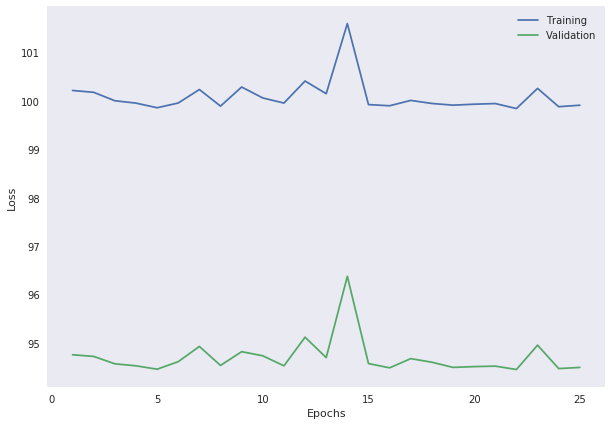

In [31]:
# Plot the results
epochs = np.arange(1,26)
train_loss = []
valid_loss = []
for e in epochs:
    print("Training with %d epochs..." % e)
    t, v = train_for_epochs(e)
    train_loss.append(t)
    valid_loss.append(v)
    
plt.figure(figsize=(10,7))
plt.plot(epochs, train_loss, label='Training')
plt.plot(epochs, valid_loss, label='Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()

So the model does not look exceptionally good. This is normal, we have just tried a linear model without any kind of feature engineering or transformation; we don't know for instance if the relationship between *fare_amount* and the rest of features is linear or not.

Let's try another simple model using TF, but this one will be more complex

## A more complex model

We are going to reuse a lot of code from the previous model, we will just change the kind of estimator we are using.

Let's repeat the same estimator again, and we will run it for 20 epochs this time. Then we will compare it with the new one:

Training with 1 epochs...
Training with 2 epochs...
Training with 3 epochs...
Training with 4 epochs...
Training with 5 epochs...
Training with 6 epochs...
Training with 7 epochs...
Training with 8 epochs...
Training with 9 epochs...
Training with 10 epochs...
Training with 11 epochs...
Training with 12 epochs...
Training with 13 epochs...
Training with 14 epochs...
Training with 15 epochs...
Training with 16 epochs...
Training with 17 epochs...
Training with 18 epochs...
Training with 19 epochs...
Training with 20 epochs...
Training with 21 epochs...
Training with 22 epochs...
Training with 23 epochs...
Training with 24 epochs...
Training with 25 epochs...
Training with 26 epochs...
Training with 27 epochs...
Training with 28 epochs...
Training with 29 epochs...
Training with 30 epochs...
Training with 31 epochs...
Training with 32 epochs...
Training with 33 epochs...
Training with 34 epochs...
Training with 35 epochs...
Training with 36 epochs...
Training with 37 epochs...
Training w

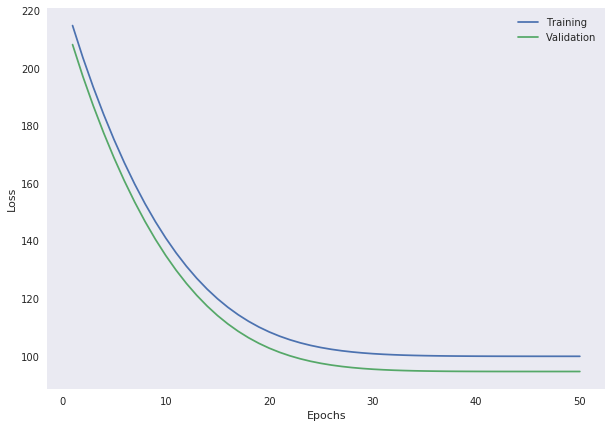

In [36]:
tf.logging.set_verbosity(tf.logging.ERROR)
OUTDIR = 'taxi_trained'
shutil.rmtree(OUTDIR, ignore_errors = True) # start fresh each time
    
def train_for_epochs(nepochs):
    tf_train = pandas2tf(df_train, nepochs)
    tf_valid = pandas2tf(df_valid, nepochs)
    tf_test = pandas2tf(df_test, nepochs)
    
    model = tf.estimator.DNNRegressor(feature_columns=feature_cols,
                                      hidden_units=[32,8,2], # 3 capas con sus dimensiones
                                      model_dir=OUTDIR,
                                      config=tf.estimator.RunConfig().replace(save_summary_steps=1))
    model.train(tf_train)
    train_loss = model.evaluate(tf_train)['average_loss']
    valid_loss = model.evaluate(tf_valid)['average_loss']
    return train_loss, valid_loss

# Plot the results
epochs = np.arange(1,51)
train_loss = []
valid_loss = []
for e in epochs:
    print("Training with %d epochs..." % e)
    t, v = train_for_epochs(e)
    train_loss.append(t)
    valid_loss.append(v)
    
plt.figure(figsize=(10,7))
plt.plot(epochs, train_loss, label='Training')
plt.plot(epochs, valid_loss, label='Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()

Is this new model better? Why does not the linear model change with the number of epochs?

What would you do next to improve the Deep Learning model?
* Possible answers: increase the number of epochs, maybe try a more complex model. Any other hyperparam?

Let's try with 150 epochs, and see if we can beat the training and validation loss

In [7]:
import shutil
tf.logging.set_verbosity(tf.logging.ERROR)
OUTDIR = 'taxi_trained'
shutil.rmtree(OUTDIR, ignore_errors = True) # start fresh each time

def train_for_epochs(nepochs):
    tf_train = pandas2tf(df_train, nepochs)
    tf_valid = pandas2tf(df_valid, nepochs)
    tf_test = pandas2tf(df_test, nepochs)
    
    dnn = tf.estimator.DNNRegressor(feature_columns=feature_cols,
                                      hidden_units=[32,8,2], # 3 capas con sus dimensiones
                                      model_dir=OUTDIR,
                                      config=tf.estimator.RunConfig().replace(save_summary_steps=1))
    
    linear = tf.estimator.LinearRegressor(feature_columns=feature_cols,
                                         model_dir=OUTDIR,
                                         config=tf.estimator.RunConfig().replace(save_summary_steps=1))
    
    dnn.train(tf_train)
    linear.train(tf_train)
    
    dnn_train_loss = dnn.evaluate(tf_train)['average_loss']
    dnn_valid_loss = dnn.evaluate(tf_valid)['average_loss']
    
    linear_train_loss = linear.evaluate(tf_train)['average_loss']
    linear_valid_loss = linear.evaluate(tf_valid)['average_loss']
    
    return dnn_train_loss, dnn_valid_loss, linear_train_loss, linear_valid_loss

# Plot the results
epochs = np.arange(1,16)
dnn_train_loss = []
dnn_valid_loss = []
linear_train_loss = []
linear_valid_loss = []

for e in epochs:
    print("Training with %d epochs..." % e)
    dnn_t, dnn_v, linear_t, linear_v = train_for_epochs(e)
    dnn_train_loss.append(dnn_t)
    dnn_valid_loss.append(dnn_v)
    linear_train_loss.append(linear_t)
    linear_valid_loss.append(linear_v)

Training with 1 epochs...


NotFoundError: Restoring from checkpoint failed. This is most likely due to a Variable name or other graph key that is missing from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Key linear/linear_model/bias_weights not found in checkpoint
	 [[{{node save/RestoreV2_1}} = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2_1/tensor_names, save/RestoreV2_1/shape_and_slices)]]

Caused by op 'save/RestoreV2_1', defined at:
  File "/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 499, in start
    self.io_loop.start()
  File "/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/anaconda3/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/anaconda3/lib/python3.6/asyncio/base_events.py", line 1434, in _run_once
    handle._run()
  File "/anaconda3/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 346, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 259, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 513, in execute_request
    user_expressions, allow_stdin,
  File "/anaconda3/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2817, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2843, in _run_cell
    return runner(coro)
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3018, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3183, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3265, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-cf0242598489>", line 37, in <module>
    dnn_t, dnn_v, linear_t, linear_v = train_for_epochs(e)
  File "<ipython-input-7-cf0242598489>", line 20, in train_for_epochs
    linear.train(tf_train)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/estimator/estimator.py", line 356, in train
    loss = self._train_model(input_fn, hooks, saving_listeners)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/estimator/estimator.py", line 1181, in _train_model
    return self._train_model_default(input_fn, hooks, saving_listeners)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/estimator/estimator.py", line 1215, in _train_model_default
    saving_listeners)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/estimator/estimator.py", line 1406, in _train_with_estimator_spec
    log_step_count_steps=self._config.log_step_count_steps) as mon_sess:
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 504, in MonitoredTrainingSession
    stop_grace_period_secs=stop_grace_period_secs)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 921, in __init__
    stop_grace_period_secs=stop_grace_period_secs)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 643, in __init__
    self._sess = _RecoverableSession(self._coordinated_creator)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 1107, in __init__
    _WrappedSession.__init__(self, self._create_session())
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 1112, in _create_session
    return self._sess_creator.create_session()
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 800, in create_session
    self.tf_sess = self._session_creator.create_session()
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 557, in create_session
    self._scaffold.finalize()
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 215, in finalize
    self._saver.build()
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1106, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1143, in _build
    build_save=build_save, build_restore=build_restore)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 781, in _build_internal
    restore_sequentially, reshape)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 459, in _AddShardedRestoreOps
    name="restore_shard"))
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 406, in _AddRestoreOps
    restore_sequentially)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 854, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1466, in restore_v2
    shape_and_slices=shape_and_slices, dtypes=dtypes, name=name)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3272, in create_op
    op_def=op_def)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1768, in __init__
    self._traceback = tf_stack.extract_stack()

NotFoundError (see above for traceback): Restoring from checkpoint failed. This is most likely due to a Variable name or other graph key that is missing from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Key linear/linear_model/bias_weights not found in checkpoint
	 [[{{node save/RestoreV2_1}} = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2_1/tensor_names, save/RestoreV2_1/shape_and_slices)]]


In [ ]:
plt.figure(figsize=(10,7))
plt.plot(epochs, dnn_train_loss, label='DNN Training')
plt.plot(epochs, dnn_valid_loss, label='DNN Validation')
plt.plot(epochs, linear_train_loss, label='LM Training')
plt.plot(epochs, linear_valid_loss, label='LM Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()

## Final decision about the models

So far, we have been ignoring the test set. We have used the validation dataset to change the hyperparameters of the model. It is now the turn to use the test set to finally decide which model is better: the linear regressor or the neural network.

For this, we can retrain the models using both the train and validation sets, with the hyperparameters that we have already decided. Then we will evaluate both models using only the test set, and we will find out which one is better predicting the test set, that is, a set of data that has not been used in any way to tune the model (the validation set has been used to tune the hyperparams, so somehow the validation set info is already included in the model).

In [ ]:
# Evaluate the LinearRegressor model

In [ ]:
# Evaluate tf.estimator.DNNRegressor model